# Water Potability Classification Hackathon by IndabaX Nigeria 2021

The objective of this task is to create a binary classification machine learning model to predict if water is potable or not.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [1]:
#Importing necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

In [4]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/Competition\ notebook

/content/drive/My Drive/Colab Notebooks/Competition notebook


In [6]:
#Loading the dataset
path = '~/Documents/ML-USU-SP21-main/personal/water-portability-classification/'
train_raw = pd.read_csv(path +'Train.csv')
test_raw = pd.read_csv(path + 'Test.csv')
submission = pd.read_csv(path + 'SampleSubmission.csv')

In [7]:
train_raw.head()

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0
3,region_area_1001,NaN,261.753637,21174.713291,7.314074,NaN,582.848407,15.215849,90.367455,4.217553,0
4,region_area_1002,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0


### Preprocessors

In [8]:
#A function to drop columns
def drop_column(train_, test_, col_names = []):
    ''' drops specified column'''
    for a in col_names:
        train_ = train_.drop(a, axis = 1)
        test_ = test_.drop(a, axis = 1)
        return train_, test_

#function to print the shape train and test
def print_shape(train, test):
    '''prints the shape of the dataset'''
    print('Shape of train {}'.format(train.shape))
    print('Shape of test {}'.format(test.shape))

#function to replace missing value by mean of col    
def replace_nan(cols = [], mean = True):
    '''Replaces missing with mean'''
    if mean:
        for col in cols:
            train[col] = train[col].fillna(train[col].mean())
            test[col] = test[col].fillna(test[col].mean())
            print(col, train[col].isna().sum() == test[col].isna().sum())

#function for dealing with outliers
def outliers_removal(col, upper, lower = 0, u_rep = None, l_rep = None):
  if u_rep:
    train[col] = np.where((train[col] >= upper), u_rep, train[col] )
    test[col] = np.where((test[col] >= upper), u_rep, test[col] )
  
  if l_rep:
    train[col] = np.where((train[col] <= lower), l_rep, train[col] )
    test[col] = np.where((test[col] <= lower), l_rep, test[col] )
  
  sns.boxplot(train[col])            
            
#function for saving the submission file
def submit(pred,div = 1,name = ""):
    pred_mean = pred/div
    submission['Potability'] = pred_mean.astype(int)
    submission.to_csv(name,index=False)
    
#Function for Frequency encoding
def freq_encoding(data, col):
    encoding = data.groupby(np.round(data[col])).size()
    encoding = encoding/len(data)
    data[str(col) + 'enc'] = np.round(data[col]).map(encoding)
    return data

#Function for creating a dataframe based on order of importance of features
def feat_imp_sorter(model, x):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    feature_imp = pd.DataFrame(zip(model.feature_importances_,x.columns), columns=['Value','Features'])
    feature_imp.sort_values(by='Value',ignore_index=True, ascending=False, inplace = True)
    return feature_imp
    
#fUnction for ploting barplot for the feature importance of any model    
def feat_imp_ploter(model,x):
    sorted_feat = feat_imp_sorter(model,x)
    
    # plt.figure(figsize=(10, 10))
    sns.barplot(x="Value", y="Features", data=sorted_feat)
    plt.title(str(model) +'Features_important')
    plt.tight_layout()



## EDA

In [9]:
print(train_raw['region_area_'].nunique())
print(train_raw.shape)

2260
(2260, 11)


In [10]:
print(test_raw['region_area_'].nunique())
print(test_raw.shape)

1016
(1016, 10)


In [11]:
# Since the whole records have a unique of the column it is therefore not useful and should be dropped
train, test = drop_column(train_raw, test_raw, col_name= 'region_area_')
print_shape(train, test)

Shape of train (2260, 10)
Shape of test (1016, 9)


In [12]:
train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0
1,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0
3,NaN,261.753637,21174.713291,7.314074,NaN,582.848407,15.215849,90.367455,4.217553,0
4,9.323584,263.484560,15751.480111,5.196259,297.593625,409.878704,10.727265,74.669285,3.006650,0


In [13]:
train.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1924.000000,2260.000000,2260.000000,2260.000000,1713.000000,2260.000000,2260.000000,2149.000000,2260.000000,2260.000000
mean,7.083561,247.000935,22100.926521,6.802715,334.601013,436.572437,14.359075,66.440129,3.969176,0.388496
std,1.596243,33.162065,8829.474740,1.592352,42.216115,80.645313,3.298100,16.321315,0.777228,0.487516
min,0.000000,124.266124,321.247422,0.047189,129.745113,211.724737,4.476899,0.853000,1.450000,0.000000
25%,6.114364,226.799112,15761.393491,5.800652,307.637713,376.894507,12.154291,55.918503,3.444178,0.000000
50%,7.060886,247.379235,21149.453853,6.828266,333.943304,432.813965,14.325645,66.727984,3.962502,0.000000
75%,8.045673,267.798367,27347.271380,7.802569,361.159118,492.076858,16.625857,77.488813,4.502519,1.000000
max,13.541240,373.897891,61227.500818,12.822189,481.775755,718.331364,28.405000,124.115000,6.739000,1.000000


In [14]:
test.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,861.000000,1016.000000,1016.000000,1016.000000,782.000000,1016.000000,1016.000000,965.000000,1016.000000
mean,7.074613,247.460258,21821.921001,6.850280,334.345377,435.726589,14.458693,66.669771,3.961470
std,1.590921,32.256846,8632.753833,1.562552,39.635543,81.257054,3.331036,15.851561,0.787713
min,0.227499,98.205891,729.055640,1.086060,192.778705,191.588754,2.305000,14.458161,1.496101
25%,6.032189,228.453631,15412.001500,5.891916,310.791491,375.045634,12.231513,55.985245,3.426879
50%,6.985304,248.207598,20425.683193,6.807689,332.858280,429.830549,14.308943,66.776479,3.928238
75%,8.070477,266.930167,27287.213813,7.826017,359.042280,491.194353,16.714639,77.408940,4.489146
max,14.000000,358.479915,52319.222108,12.322089,459.186185,763.447620,27.111707,118.472275,6.494249


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260 entries, 0 to 2259
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1924 non-null   float64
 1   Hardness         2260 non-null   float64
 2   Solids           2260 non-null   float64
 3   Chloramines      2260 non-null   float64
 4   Sulfate          1713 non-null   float64
 5   Conductivity     2260 non-null   float64
 6   Organic_carbon   2260 non-null   float64
 7   Trihalomethanes  2149 non-null   float64
 8   Turbidity        2260 non-null   float64
 9   Potability       2260 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 176.7 KB


<AxesSubplot:>

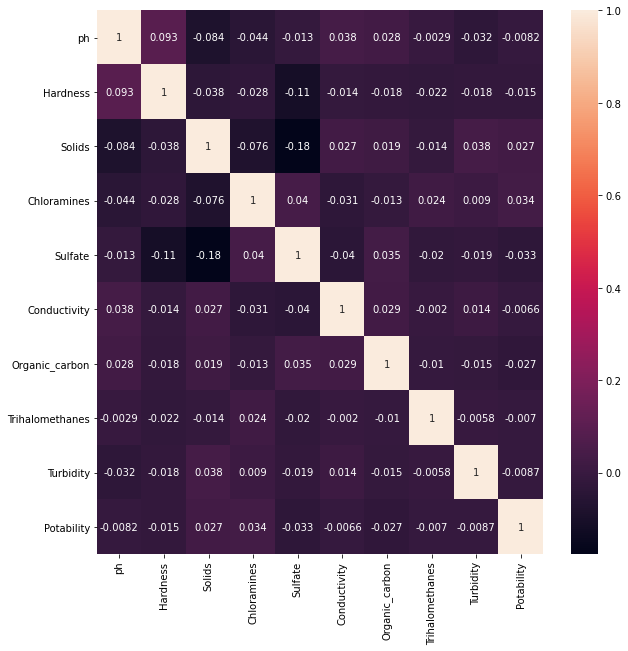

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot= True)

In [17]:
train['Potability'].value_counts(normalize=True)

0    0.611504
1    0.388496
Name: Potability, dtype: float64

#### Missing columns

In [18]:
#filling missing column
missing_col = ['ph', 'Sulfate', 'Trihalomethanes']
replace_nan(cols = missing_col)

ph True
Sulfate True
Trihalomethanes True


#### Outliers

The outliers were handled using the description given for each variable

<AxesSubplot:xlabel='Solids'>

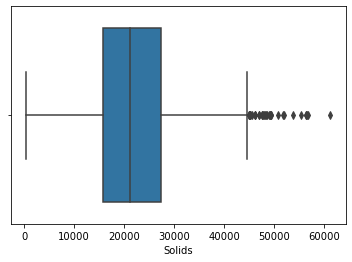

In [19]:
sns.boxplot(train['Solids'])

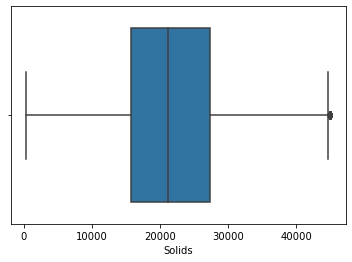

In [20]:
outliers_removal('Solids',upper=45000, u_rep = 45000)

<AxesSubplot:xlabel='ph'>

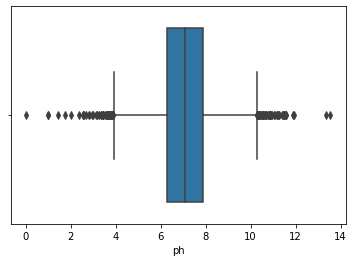

In [21]:
sns.boxplot(train['ph'])

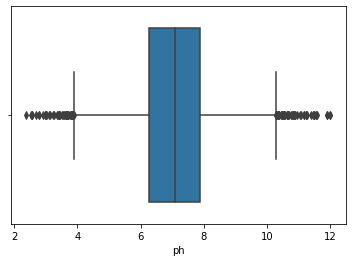

In [23]:
outliers_removal('ph',upper=12, u_rep = 12, lower = 2, l_rep = 3)

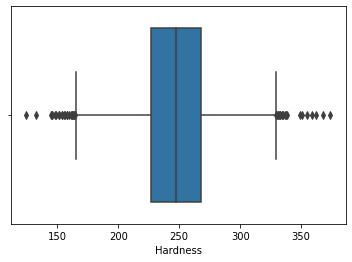

In [145]:
sns.boxplot(train['Hardness'])

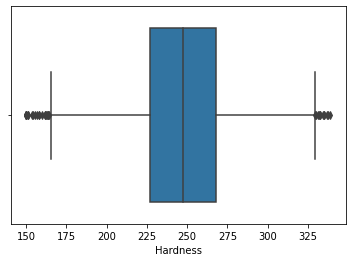

In [146]:
outliers_removal('Hardness',upper=340, u_rep = 300, lower = 150, l_rep = 150)

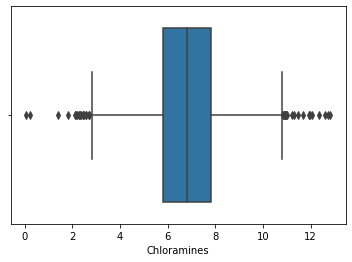

In [147]:
sns.boxplot(train['Chloramines'])

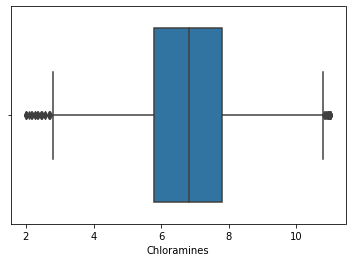

In [148]:
outliers_removal('Chloramines',upper=11, u_rep = 11, lower =2, l_rep =2)

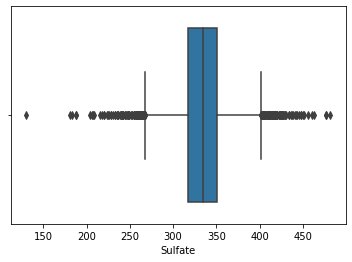

In [149]:
sns.boxplot(train['Sulfate'])

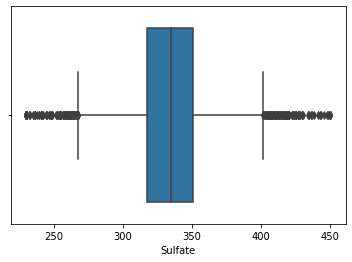

In [150]:
outliers_removal('Sulfate',upper=450, u_rep = 450, lower =230, l_rep =230)

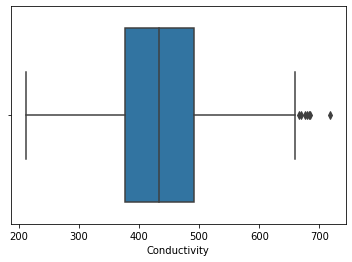

In [151]:
sns.boxplot(train['Conductivity'])

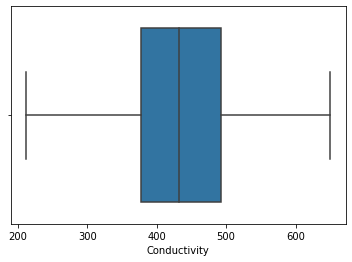

In [152]:
outliers_removal('Conductivity',upper=650, u_rep = 650)

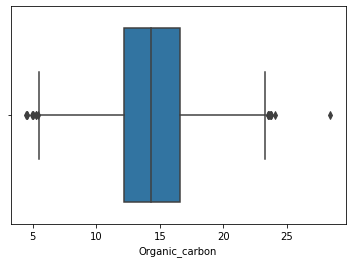

In [153]:
sns.boxplot(train['Organic_carbon'])

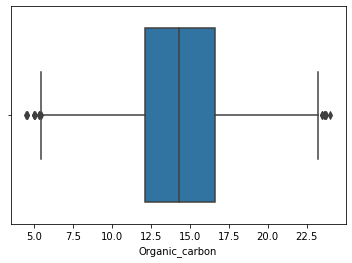

In [154]:
outliers_removal('Organic_carbon',upper=25, u_rep = 23)

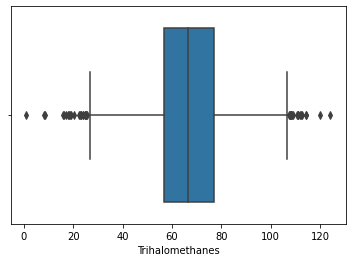

In [155]:
sns.boxplot(train['Trihalomethanes'])

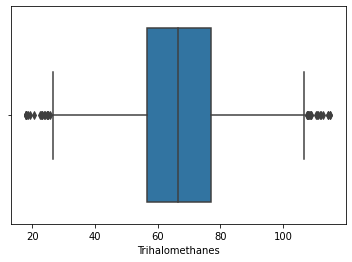

In [156]:
outliers_removal('Trihalomethanes',upper= 115, u_rep = 115, lower =18, l_rep =18)

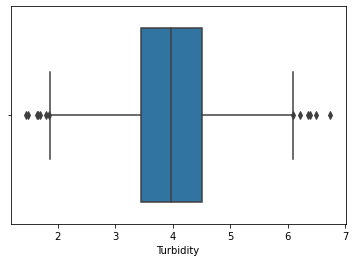

In [157]:
sns.boxplot(train['Turbidity'])

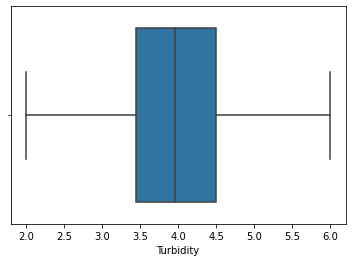

In [158]:
outliers_removal('Turbidity',upper= 6, u_rep = 6, lower =2, l_rep =2)

## Feature Engineering

In [159]:
#Frequency encoding
train = freq_encoding(train,col = 'ph')
test = freq_encoding(test,col='ph')

In [160]:
#Frequency encoding
train = freq_encoding(train,col = 'Turbidity')
test = freq_encoding(test,col='Turbidity')

In [161]:
train['wn'] = train['ph'] * 0.9 + train['Hardness'] * 0.035 + train['Solids'] * 0.001 + train['Chloramines'] * 0.9 + \
                train['Sulfate'] * 0.035 + train['Conductivity'] * 0.053 + train['Organic_carbon'] * 0.2 + \
                    train['Trihalomethanes'] * 0.04 + train['Turbidity'] * 0.1

test['wn'] = test['ph'] * 0.9 + test['Hardness'] * 0.035 + test['Solids'] * 0.001 + test['Chloramines'] * 0.9 + \
                test['Sulfate'] * 0.035 + test['Conductivity'] * 0.053 + test['Organic_carbon'] * 0.2 + \
                    test['Trihalomethanes'] * 0.04 + test['Turbidity'] * 0.1

In [164]:
train[(train['wn'] < 100) & (train['Potability'] == 0)].shape

(1299, 15)

In [162]:
#Frequency encoding
train = freq_encoding(train,col = 'Solids')
test = freq_encoding(test,col='Solids')

In [163]:
train['ph_p'] = np.where((train['ph'] >= 6.5) & (train['ph']<= 8.5), 1, 0)
test['ph_p'] = np.where((test['ph'] >= 6.5) & (test['ph']<= 8.5), 1, 0)

In [165]:
train['wn_n'] = np.where(train['wn'] < 100, 1, 0 )
test['wn_n'] = np.where(test['wn'] < 100, 1, 0 )

In [166]:
f1_score(train['Potability'], train['wn_n'])

0.5462437395659433

#### Other features to consider

In [297]:
# train['qi'] = np.where((train['ph']>=6.5) & (train['ph']<=6.83), 1, 0)
# train['qi'] = np.where((train['Hardness']/ 10 <=1000), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Solids']<=500), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Chloramines']<=8), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Sulfate']<=350), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Conductivity']<= 400), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Organic_carbon']<= 16), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Trihalomethanes']<= 80), train['qi'] + 1, train['qi'])
# train['qi'] = np.where((train['Turbidity']< 3), train['qi'] + 1, train['qi'])

# test['qi'] = np.where((test['ph']>=6.5) & (test['ph']<=6.83), 1, 0)
# test['qi'] = np.where((test['Hardness']/ 10 <=1000), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Solids']<=500), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Chloramines']<=8), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Sulfate']<=350), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Conductivity']<= 400), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Organic_carbon']<= 16), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Trihalomethanes']<= 80), test['qi'] + 1, test['qi'])
# test['qi'] = np.where((test['Turbidity']< 3), test['qi'] + 1, test['qi'])

In [ ]:
# train['wqi'] = np.where(train['qi'] >=4, 1, 0)
# test['wqi'] = np.where(test['qi'] >=4, 1, 0)

# train['wqi'] = np.where(train['ph_p'] ==1 , 1, train['wqi'])
# test['wqi'] = np.where(test['ph_p'] == 1, 1, test['wqi'])

In [307]:
# #Performing Prinicipal Component Analysis on the data
# pca =  PCA(1)
# train_trans = pca.fit_transform(train.drop(['Potability'], axis = 1))
# test_trans = pca.transform(test)

# #Merging the reduced data to the real dataset
# train = pd.merge(train, pd.DataFrame(train_trans, columns=['pca1']),left_index=True,right_index=True)
# test = pd.merge(test, pd.DataFrame(test_trans,columns=['pca1']),left_index=True,right_index=True)

In [336]:
# f1_score(train['Potability'], train['wqi'])

0.5387610619469027

In [337]:
# X_train, X_test, y_train, y_test = train_test_split(train, train['Potability'], test_size=0.3, random_state=42 )

In [339]:
# f1_score(X_train['Potability'], X_train['wqi'])

0.5451792024230186

In [340]:
# f1_score(X_test['Potability'], X_test['wqi'])

0.523696682464455

In [341]:
# submit(test['wqi'], div= 1, name='wqi4ph_p.csv')

# Modelling

In [168]:
y = train['Potability']
X = train.drop('Potability', axis = 1)
print_shape(train, test)

Shape of train (2260, 16)
Shape of test (1016, 15)


In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X)
# scaled_x = scaler.transform(X)
# scaled_test = scaler.transform(test)

### CATBOOST

In [ ]:
# I learnt a new lesson: the order of the features matters

Shape of train (2260, 16)
Shape of test (1016, 15)
================================Fold0====================================
0.43243243243243246
0.5831775700934579
================================Fold1====================================
0.4744525547445255
0.58203125
================================Fold2====================================
0.43243243243243246
0.5703839122486288
================================Fold3====================================
0.4571428571428572
0.6064030131826742
================================Fold4====================================
0.39382239382239387
0.58195211786372
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')
0.4380565341149283
0.5847895726776962
761


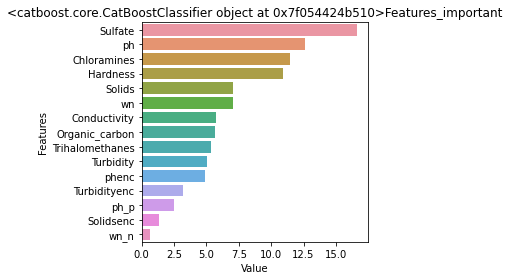

In [169]:
# This produce my private leaderboard position 11th with the score of 0.597849462365591
y = train['Potability']
X = train.drop('Potability', axis = 1)
print_shape(train, test)

kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.26
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
print(np.where(cat_pred/5 > thresh, 1, 0).sum())

feat_imp_ploter(cat, X)

Shape of train (2260, 16)
Shape of test (1016, 15)
================================Fold0====================================
0.43243243243243246
0.5767918088737202
================================Fold1====================================
0.4744525547445255
0.5800711743772242
================================Fold2====================================
0.43243243243243246
0.5714285714285714
================================Fold3====================================
0.4571428571428572
0.5975820379965459
================================Fold4====================================
0.39382239382239387
0.5757575757575758
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')
0.4380565341149283
0.5803262336867274
874


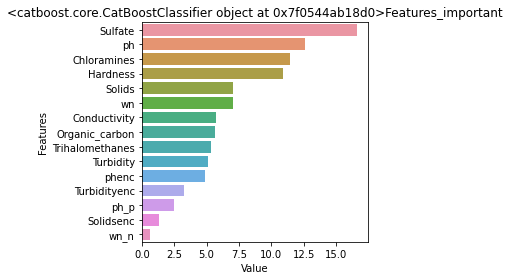

In [170]:
#This produce my  best private leaderboard of 0.601769911504425 but was not choosen
#the only difference was the thresh of 0.2 instead of 0.26
y = train['Potability']
X = train.drop('Potability', axis = 1)
print_shape(train, test)

kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.2
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
print(np.where(cat_pred/5 > thresh, 1, 0).sum())

feat_imp_ploter(cat, X)

Shape of train (2260, 18)
Shape of test (1016, 17)
================================Fold0====================================
0.43410852713178294
0.5833333333333334
================================Fold1====================================
0.45864661654135336
0.6021052631578948
================================Fold2====================================
0.37768240343347637
0.5850091407678245
================================Fold3====================================
0.4094488188976378
0.5849802371541502
================================Fold4====================================
0.3709677419354838
0.5831702544031311
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'wn_n', 'qi', 'ph_p', 'wqi', 'pca1'],
      dtype='object')
0.4101708215879468
0.5877196457632669
758


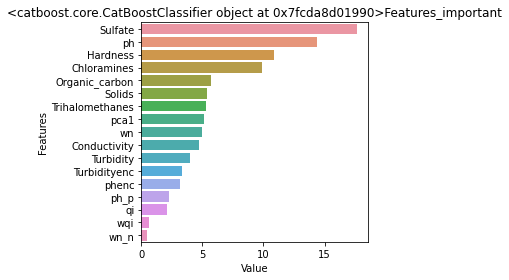

In [ ]:
# This gave a score of 0.592910848549946
y = train['Potability']
X = train.drop('Potability', axis = 1)
print_shape(train, test)

kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
print(np.where(cat_pred/5 > thresh, 1, 0).sum())

feat_imp_ploter(cat, X)

In [ ]:
submit(pred_cat.astype(int), div= 1, name='cat03(58.7_41).csv')

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]
print(X.columns)

================================Fold0====================================
0.4258555133079848
0.5979797979797981
================================Fold1====================================
0.4688644688644688
0.6039387308533917
================================Fold2====================================
0.40625
0.5685483870967741
================================Fold3====================================
0.44943820224719094
0.5829787234042553
================================Fold4====================================
0.36213991769547327
0.5834932821497121
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'wn_n', 'qi', 'ph_p', 'wqi'],
      dtype='object')


In [ ]:
print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'wn_n', 'qi', 'ph_p', 'wqi'],
      dtype='object')
0.4225096204230236
0.5873877842967863


728

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
0.42276422764227645
0.6061776061776062
================================Fold1====================================
0.4477611940298507
0.5982905982905983
================================Fold2====================================
0.36134453781512604
0.5625
================================Fold3====================================
0.4535315985130112
0.5860655737704918
================================Fold4====================================
0.37301587301587297
0.5731462925851704


In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
0.42801556420233466
0.5951417004048583
================================Fold1====================================
0.4575645756457565
0.5933609958506224
================================Fold2====================================
0.39357429718875503
0.565891472868217
================================Fold3====================================
0.4444444444444445
0.6113537117903929
================================Fold4====================================
0.37606837606837606
0.5878003696857671


In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.25
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]
print(X.columns)

================================Fold0====================================
0.4108527131782945
0.5863309352517985
================================Fold1====================================
0.4558823529411764
0.5866666666666667
================================Fold2====================================
0.4063745019920319
0.5719360568383659
================================Fold3====================================
0.4542124542124542
0.6
================================Fold4====================================
0.3203463203463204
0.5728643216080402
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n', 'pca1', 'pca2'],
      dtype='object')


In [ ]:
print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n', 'pca1', 'pca2'],
      dtype='object')
0.4095336685340555
0.5835595960729743


790

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.26
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]
print(X.columns)

================================Fold0====================================
0.43243243243243246
0.5831775700934579
================================Fold1====================================
0.4744525547445255
0.58203125
================================Fold2====================================
0.43243243243243246
0.5703839122486288
================================Fold3====================================
0.4571428571428572
0.6064030131826742
================================Fold4====================================
0.39382239382239387
0.58195211786372
Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')


In [ ]:
X.drop('Turbidityenc', axis = 1, inplace = True)

In [ ]:
print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')
0.4380565341149283
0.5847895726776962


761

In [ ]:
print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')
0.4380565341149283
0.5803262336867274


874

In [ ]:
f1_score(b, np.where(blend >= 0.5, 1, 0))

0.9796987557301899

In [ ]:
print(X.columns)
print(np.mean(cat_scores))
print(np.mean(cat_proba))
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
       'Turbidityenc', 'wn', 'Solidsenc', 'ph_p', 'wn_n'],
      dtype='object')
0.4380565341149283
0.5819760552118638


582

In [ ]:
a = pd.read_csv('cat03(57.8).csv')['Potability']
b = pd.read_csv('cat03(59.0).csv')['Potability']
c = pd.read_csv('cat026(58.4_43).csv')['Potability']

In [ ]:
c = pd.read_csv('cat026(58.4_43).csv')['Potability']

In [ ]:
c.sum()

761

In [ ]:
blend = (a + b+c + pred_cat)/4

In [ ]:
np.where(blend >= 0.5, 1, 0).sum()

772

In [ ]:
np.where(blend >= 0.5, 1, 0).sum()

783

In [ ]:
# ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
#        'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'phenc',
#        'Turbidityenc', 'wn'] # gave me this score.
print(np.mean(cat_scores))
print(np.mean(cat_proba))

0.40156374187987665
0.5883918509081096


In [ ]:
print(np.mean(cat_scores))
print(np.mean(cat_proba))

0.3811953619779838
0.591415444983841


In [ ]:
0.4199 + 0.5907

1.0106

In [ ]:
print(np.mean(cat_scores))
print(np.mean(cat_proba))

0.41993345150993333
0.5907096501199715


In [ ]:
cat_pred/5

array([0.39366993, 0.48374602, 0.28480984, ..., 0.34535715, 0.28259206,
       0.36609408])

In [ ]:
cat_pred/5

array([0.39363751, 0.48059869, 0.31664656, ..., 0.3247042 , 0.28082515,
       0.32165936])

In [ ]:
test.columns == X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

755

In [ ]:
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

770

In [ ]:
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

743

In [ ]:
submit(np.where(blend >= 0.5, 1, 0), div= 1, name='blend.csv')

In [ ]:
submit(pred_cat.astype(int), div= 1, name='cat026(58.4_43).csv')

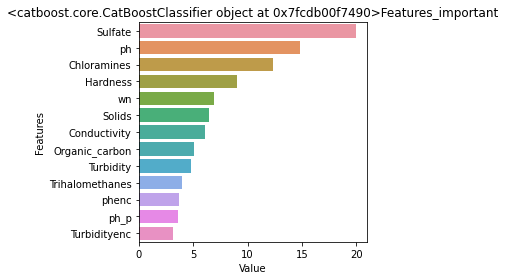

In [ ]:
feat_imp_ploter(cat, X)

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=43,shuffle=True)
scores1 = []
test_ = 0
test_pred = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    model = RandomForestClassifier(random_state=7)
# xgb_model.fit(X, y)
    model.fit(X_train,y_train)
    scores1.append(f1_score(y_test,model.predict(X_test)))
    print(f1_score(y_test, np.where(model.predict_proba(X_test)[:,1] > 0.1, 1, 0)))
    test_+=model.predict_proba(test)[:,1]
    test_pred += model.predict(test)

================================Fold0====================================
0.5582137161084529
================================Fold1====================================
0.5591054313099042
================================Fold2====================================
0.5614035087719299
================================Fold3====================================
0.5614035087719299
================================Fold4====================================
0.5605095541401274


In [ ]:
scores1

[0.41538461538461535,
 0.3955223880597016,
 0.35245901639344257,
 0.3671875,
 0.3663003663003663]

In [ ]:
np.where(test_/5 > 0.1, 1, 0).sum()

1016

In [ ]:
test_pred.sum()

869.0

In [ ]:
submit(test_.astype(int), div= 1, name='rfproba0.1.csv')

In [ ]:
scores1

[0.4392156862745098,
 0.4187725631768953,
 0.3140495867768595,
 0.4117647058823529,
 0.39062500000000006]

In [ ]:
test_pred/=2

In [ ]:
test_pred.sum()

1013.0

In [ ]:
submit(test_pred.astype(int), div= 1, name='passiveac056.csv')

In [ ]:
pd.read_csv('passiveac056.csv')

,region_area_,Potability
0,region_area_0,1
1,region_area_10,1
2,region_area_1006,1
3,region_area_1010,1
4,region_area_1011,1
...,...,...
1011,region_area_986,1
1012,region_area_987,1
1013,region_area_989,1
1014,region_area_995,1


In [ ]:
#Things to consider
#you might consider filling ph and sulphate using linearreg
#try giving back the region area result for train back for test

In [ ]:
from sklearn.svm import NuSVC

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=43,shuffle=True)
scores1 = []
test_pred = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    model = KNeighborsClassifier(n_neighbors=10)
# xgb_model.fit(X, y)
    model.fit(X_train,y_train)
    scores1.append(f1_score(y_test,model.predict(X_test)))
    print(f1_score(y_test, np.where(model.predict_proba(X_test)[:,1] > 0.1, 1, 0)))
#     test_pred += model.predict(test)

================================Fold0====================================
0.5572139303482586
================================Fold1====================================
0.5370675453047776
================================Fold2====================================
0.5544554455445545
================================Fold3====================================
0.5599999999999999
================================Fold4====================================
0.5503355704697986


In [ ]:
scores1

[0.20869565217391303,
 0.2184873949579832,
 0.24267782426778245,
 0.19409282700421943,
 0.22400000000000003]

In [ ]:
new_train = train[['ph', 'Chloramines','Turbidity',  'ph_p', 'wqi', 'qi', 'Potability']]

In [ ]:
y = train['Potability']
X = new_train.drop('Potability', axis = 1)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_x = scaler.transform(X)
scaled_test = scaler.transform(test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=43,shuffle=True)
scores1 = []
test_pred = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    model = QuadraticDiscriminantAnalysis()
# xgb_model.fit(X, y)
    model.fit(X_train,y_train)
    scores1.append(f1_score(y_test,model.predict(X_test)))
    print(f1_score(y_test, np.where(model.predict_proba(X_test)[:,1] > 0.1, 1, 0)))
#     test_pred += model.predict(test)

================================Fold0====================================
0.555956678700361
================================Fold1====================================
0.5026737967914439
================================Fold2====================================
0.5612052730696798
================================Fold3====================================
0.5551470588235294
================================Fold4====================================
0.3949843260188088


In [ ]:
np.mean(scores1)

0.4195292252245458

### LGBM

In [ ]:
skfold =StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
scoreslgb = []
test_scoreslgb = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(skfold.split(X,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb = LGBMClassifier(n_estimators=1000, learning_rate=0.01, 
                     max_depth=7,random_state = 7)#10,7
    lgb.fit(X_train,y_train)
    _ = lgb.predict(X_test)
    scoreslgb.append(f1_score(y_test,_))
    print(f1_score(y_test, np.where(lgb.predict_proba(X_test)[:,1] > 0.2, 1, 0)))
    test_scoreslgb += lgb.predict_proba(test)[:,1]

============================Fold0================================
0.5663082437275985
============================Fold1================================
0.578544061302682
============================Fold2================================
0.5631067961165048
============================Fold3================================
0.5893186003683242
============================Fold4================================
0.5813528336380256


In [ ]:
skfold =StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
scoreslgb = []
test_scoreslgb = np.zeros(len(test))
for fold,(tr_in,te_in) in enumerate(skfold.split(X,y)):
    print("============================Fold{fold}================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]
    lgb = LGBMClassifier(n_estimators=1000, learning_rate=0.01, 
                     max_depth=7,random_state = 7)#10,7
    lgb.fit(X_train,y_train)
    _ = lgb.predict(X_test)
    scoreslgb.append(f1_score(y_test,_))
    print(f1_score(y_test, np.where(lgb.predict_proba(X_test)[:,1] > 0.2, 1, 0)))
    test_scoreslgb += lgb.predict_proba(test)[:,1]

============================Fold0================================
0.5714285714285714
============================Fold1================================
0.5790476190476189
============================Fold2================================
0.5676190476190476
============================Fold3================================
0.5888888888888889
============================Fold4================================
0.5714285714285715


In [ ]:
pred = np.where(test_scoreslgb/5 > 0.2, 1, 0)
np.where(test_scoreslgb/5 > 0.2, 1, 0).sum()

863

In [ ]:
submit(pred.astype(int), div= 1, name='lgb02(56).csv')

In [ ]:
scoreslgb

[0.4329268292682927,
 0.44230769230769235,
 0.42483660130718953,
 0.4522292993630572,
 0.42990654205607476]

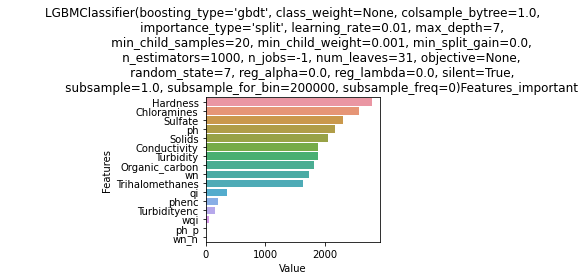

In [ ]:
feat_imp_ploter(lgb,X)

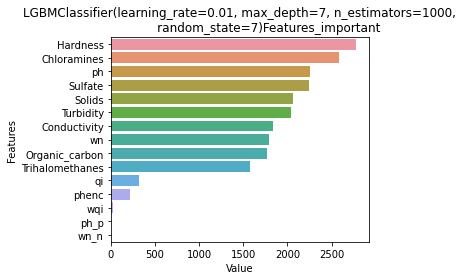

In [ ]:
feat_imp_ploter(lgb,X)

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
cat_scores = []
cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(iterations=1000, learning_rate=0.02, l2_leaf_reg=12, depth=7,
     verbose =0)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500,use_best_model=True,)
    cat_scores.append(f1_score(y_test,cat.predict(X_test)))
    cat_proba.append(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test,cat.predict(X_test)))
    print(f1_score(y_test, np.where(cat.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
0.4291187739463601
0.5903614457831325
================================Fold1====================================
0.47619047619047616
0.582441113490364
================================Fold2====================================
0.421455938697318
0.5868263473053893
================================Fold3====================================
0.4291187739463601
0.5785123966942148
================================Fold4====================================
0.3400809716599191
0.5736434108527132


In [ ]:
print(np.mean(cat_scores))
print(np.mean(cat_proba))

0.4191929868880867
0.5823569428251628


In [ ]:
cat_pred/5

array([0.39363751, 0.48059869, 0.31664656, ..., 0.3247042 , 0.28082515,
       0.32165936])

In [ ]:
pred_cat = np.where(cat_pred/5 > thresh, 1, 0)
np.where(cat_pred/5 > thresh, 1, 0).sum()

745

In [ ]:
submit(pred_cat.astype(int), div= 1, name='cat03(57.8).csv')

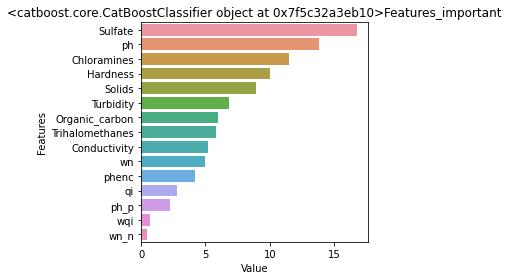

In [ ]:
feat_imp_ploter(cat,X)

### XGBOOST

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
xgb_scores = []
xgb_proba = []
xgb_pred = np.zeros(len(test))
thresh = 0.3
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    xgb = XGBClassifier(iterations=1000, learning_rate=0.02, l2_leaf_reg=12, depth=4,
     verbose =False, )
    xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=500)
    xgb_scores.append(f1_score(y_test, xgb.predict(X_test)))
    xgb_proba.append(f1_score(y_test, np.where(xgb.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    print(f1_score(y_test, xgb.predict(X_test)))
    print(f1_score(y_test, np.where(xgb.predict_proba(X_test)[:,1] > thresh, 1, 0)))
    xgb_pred +=xgb.predict_proba(test)[:,1]

================================Fold0====================================
[15:10:38] WARNING: ../src/learner.cc:541: 
Parameters: { depth, iterations, l2_leaf_reg, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68961	validation_1-logloss:0.69107
[1]	validation_0-logloss:0.68619	validation_1-logloss:0.68895
[2]	validation_0-logloss:0.68289	validation_1-logloss:0.68692
[3]	validation_0-logloss:0.67967	validation_1-logloss:0.68510
[4]	validation_0-logloss:0.67658	validation_1-logloss:0.68347
[5]	v

In [ ]:
xgb_scores

[0.3770491803278689,
 0.35918367346938773,
 0.3402489626556016,
 0.32067510548523204,
 0.22935779816513763]

In [ ]:
xgb_proba

[0.5561497326203209,
 0.5704225352112676,
 0.5604203152364272,
 0.5827586206896551,
 0.5679442508710801]

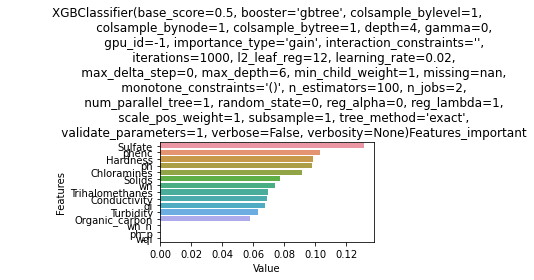

In [ ]:
feat_imp_ploter(xgb,X)